In [1]:
import os                       # For working in different directories
import numpy as np              # Data Libraries
import pandas as pd             # Data Libraries
import matplotlib.pyplot as plt # Visualization Library
import seaborn as sns           # Visualization Library
import folium                   # Visualization Library
from folium.features import GeoJsonTooltip    # Visualization Library
import branca.colormap as cm
import geopandas as gpd         # geospatial library 
import yaml                     # working w/ config file
from importnb import imports    # load other Jupyter Notebooks inside of this notebook
import pickle

# Import modeling libraries and related
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_columns', None)

# Clustering Census Places By Important Craft Beer Drinker Demographics
* Please see the Principle Component Analysis (PCA) section near the end of `DenverCraftBreweries_EDA.ipynb` for variable selection.  To recap the following variables factored in prominently from Census Bureau data profiles.  PCA revealed groupings of demograhics (variables) capturing similar explained variance, where variables found to better represent craft beer drinker demographics were kept from these groups.  Craft beer drinker demographics were determined by trade publication materials published by Brewer's Association, Harris Polls, etc (see directory `Beer Industry Research` file `Research Conclusions.ods` and Jupyter Notebook `DenverCraftBreweries_EDA`).
    - **Occupation**: total number of people with a target occupation
        - Agriculture, forestry, fishing and hunting, and mining
        - Construction
        - Professional, scientific, and management, and administrative and waste management services
        - Educational services, and health care and social assistance
        - Arts, entertainment, and recreation, and accommodation and food services
    - **Income**: select household income bands
        - $\ge$ $\$$50k
    - **Age**:
        - 25 - 54-years old
    - **Education**: total number of people with a HS diploma or greater (associates, bachelors, professional degree, etc.)
    - **Population**: 
        - total number of persons who lived at different residence (US, foreign) in the year prior to the Census survey
        - total households, married w/ children
        - total households, female w/ no spouse/partner present
        - total population male
        - total number of Hispanics
        - total number of caucasians (2018 Harris Poll indicates craft beer drinkers are 85.5% white)
        - total number of persons living in an owner-occupied home w/ a mortgage
        - total number of persons who work from home
    - **Businesses**:
        - total number of breweries
    - *** **All variables presented above were revealed to be important via Principle Component Analysis (PCA)**

## Load Scaled GeoDataFrame with Demographics & Number of Breweries

In [2]:
os.chdir("/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/models/PCA")
pca_scaled_gdf_demo = pd.read_pickle("pca_scaled_gdf_demographics.pkl")
pca_scaled_gdf_demo

,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs
0,-0.097950,0.076326,-0.222714,-0.136752,-0.150941,-0.012242,-0.156149,-0.248069,-0.202001,-0.150768,0.099840,0.017722,-0.049895,-0.194529,-0.082579,-0.090809,-0.157650,-0.083314,-0.263980,-0.121997
1,-0.300490,-0.407721,-0.325541,-0.385789,-0.371156,-0.343047,-0.374046,-0.366330,-0.396576,-0.410123,-0.384667,-0.320605,-0.399148,-0.316283,-0.363634,-0.414596,-0.382766,-0.424778,-0.350740,-0.365679
2,-0.300490,-0.424958,-0.320534,-0.372122,-0.329621,-0.351693,-0.347317,-0.336083,-0.355921,-0.391855,-0.385376,-0.378828,-0.392171,-0.301649,-0.342721,-0.395748,-0.349577,-0.399656,-0.269132,-0.338600
3,-0.300490,-0.468542,-0.337403,-0.406780,-0.374061,-0.374003,-0.394950,-0.367109,-0.397463,-0.420157,-0.423409,-0.396743,-0.437608,-0.332899,-0.387811,-0.433444,-0.398245,-0.445228,-0.347834,-0.383632
4,0.307131,0.980376,0.301590,0.699942,0.357830,0.724515,0.561258,0.387767,0.495874,0.706160,0.958299,1.166877,0.915217,0.209594,0.570072,0.736745,0.598561,0.821776,-0.033586,0.526436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,-0.300490,0.415608,-0.043709,0.062740,0.088079,-0.004984,0.118510,0.010524,0.124834,0.213693,0.113541,-0.150229,0.211094,0.060958,0.208025,0.248698,0.102354,0.188879,0.633651,0.093768
57,0.104591,0.459332,0.182203,0.327539,0.282862,0.472275,0.292733,0.219916,0.247508,0.395602,0.550330,0.608908,0.349616,0.162990,0.250878,0.380475,0.277250,0.406486,-0.042965,0.271054
58,-0.300490,-0.478212,-0.340561,-0.412928,-0.377425,-0.379020,-0.402252,-0.372302,-0.404920,-0.430192,-0.429551,-0.402528,-0.446003,-0.339878,-0.396333,-0.440422,-0.405159,-0.453089,-0.353713,-0.389736
59,-0.199220,-0.445559,-0.272086,-0.365055,-0.296188,-0.329917,-0.336219,-0.288571,-0.342429,-0.365353,-0.400731,-0.382933,-0.436360,-0.251984,-0.351244,-0.403448,-0.354333,-0.411391,-0.326697,-0.330641


## Load Unscaled GeoDataFrame with Demographics & Number of Breweries

In [3]:
os.chdir("/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/models/PCA")
gdf_pca_demo = pd.read_pickle("gdf_pca_demo_vars.pkl")
gdf_pca_demo.head()

,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,geometry
NAMELSAD,,,,,,,,,,,,,,,,,,,,,
Erie town,2,3957,1532,18336,4444,3436,12001,957,1143,2174,2241,2252,6983,3228,5191,4359,10208,25973,2717,8952,"POLYGON ((-105.10469 40.01455, -105.10380 40.0..."
Meridian Village CDP,0,503,197,1809,123,337,1379,46,47,158,190,439,826,524,541,322,929,1996,90,808,"POLYGON ((-104.83001 39.52793, -104.82992 39.5..."
Shaw Heights CDP,0,380,262,2716,938,256,2682,279,276,300,187,127,949,849,887,557,2297,3760,2561,1713,"POLYGON ((-105.05042 39.86008, -105.04054 39.8..."
Mountain View town,0,69,43,416,66,47,360,40,42,80,26,31,148,155,141,87,291,560,178,208,"POLYGON ((-105.06019 39.77661, -105.05325 39.7..."
Centennial city,6,10408,8339,73862,14427,10338,46973,5855,5074,8835,5875,8410,23997,12203,15989,14677,41378,89527,9693,30623,"MULTIPOLYGON (((-104.97913 39.56942, -104.9769..."


## Census Places - K-Means Clustering (Unsupervised ML)
* KMeans clustering is a machine learning algorithm used for partitioning a dataset into distinct groups or clusters based on similarity. It works by iteratively assigning data points to clusters and updating cluster centroids to minimize the sum of squared distances within each cluster. The process continues until convergence, resulting in a set of clusters where data points within each cluster are more similar to each other than to those in other clusters.

### Use Within Cluster Sum of Squares (WCSS) to Determine Optimal Number of Clusters
* Also known as the Elbow Method

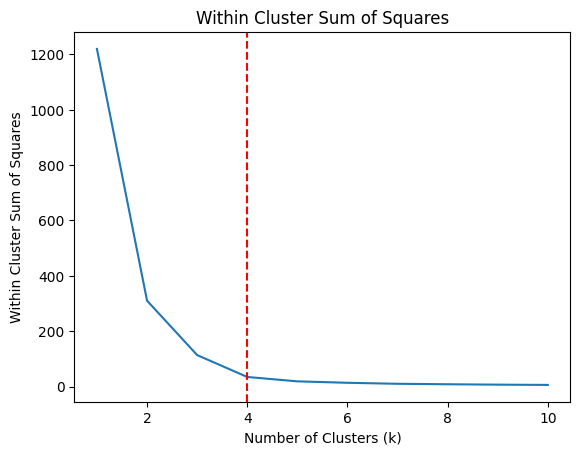

In [49]:
def plot_wcss(pca_scaled_gdf_demo, num_clusters, printWCSS=False):
    """Creates an Elbow Plot (WCSS) for Kmeans interpretation 
    to decide the optimal number of clusters used by the algorithm. The optimal number is found in the 'elbow'
    where a steep drop off occurs. The WCSS measures the sum of the squared distances between each data point 
    and the centroid of its assigned cluster. The steep drop-off or "elbow" point on the plot signifies the 
    optimal number of clusters for your data where adding more clusters does not significantly reduce the WCSS. 
    The "elbow" point represents a trade-off between having a low WCSS 
    (which would occur if you have many clusters, one for each data point) and having a small number of clusters 
    (which would result in a very high WCSS due to large within-cluster distances).
    params: 
    pca_scaled_gdf_demo{Pandas DF or GeoPandas GeoDataFrame} - a scaled dataframe
    num_clusters{int} - total number of clusters to iterate through w/ KMeans algorithm
    printWCSS{bool} - if True prints array of WCSS (per cluster) which can be a helpful companion to the graph
    returns: plot of WCSS, and if printWCSS is True an array of WCSS values per cluster
    """
    wcss = []
    for n in range(1, num_clusters + 1): 
        kmeans = KMeans(n_clusters=n, init='k-means++', n_init=10, verbose=0)
        kmeans.fit(pca_scaled_gdf_demo) 
        wcss.append(kmeans.inertia_)

    if printWCSS:
        print("WCSS: ", len(wcss), " clusters\n", wcss, sep='')    

    ks = np.arange(1, num_clusters + 1, 1)
    plt.plot(ks, wcss);

    plt.title("Within Cluster Sum of Squares")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Within Cluster Sum of Squares")
    plt.axvline(4, linestyle='--', color='r');
    
    os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/finalized_figures')
    plt.savefig('kmeans_wcss.png')
    
    return plt.show()


plot_wcss(pca_scaled_gdf_demo, 10)    # 4-clusters appears optimal

In [5]:
def kmeans_clustering(num_clusters, df, scaled_df):
    """Function to carry out KMeans clustering and append output KMeans label to end of df.
    To be used along w/ function `plot_wcss()`.
    params:
    num_clusters{int} - total number of clusters KMeans should create
    scaled_df{Pandas DF} - dataframe upon which KMeans clustering is performed
    df{Pandas DF} - the dataframe to which the clustering label is to be appended
    returns:
    df - returns df w/ new KMeans label column
    """
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=100, verbose=0)    # param: random_state
    kmeans.fit(scaled_df)
    labels = kmeans.labels_
    print(f"{len(labels)} labels:\n{labels}")
    df['kmeans_label'] = labels

    return df


kmeans_clustering(4, gdf_pca_demo, pca_scaled_gdf_demo)

61 labels:
[0 0 0 0 3 0 1 3 0 0 0 0 0 3 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0 0 0]


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,geometry,kmeans_label
NAMELSAD,,,,,,,,,,,,,,,,,,,,,,
Erie town,2,3957,1532,18336,4444,3436,12001,957,1143,2174,2241,2252,6983,3228,5191,4359,10208,25973,2717,8952,"POLYGON ((-105.10469 40.01455, -105.10380 40.0...",0
Meridian Village CDP,0,503,197,1809,123,337,1379,46,47,158,190,439,826,524,541,322,929,1996,90,808,"POLYGON ((-104.83001 39.52793, -104.82992 39.5...",0
Shaw Heights CDP,0,380,262,2716,938,256,2682,279,276,300,187,127,949,849,887,557,2297,3760,2561,1713,"POLYGON ((-105.05042 39.86008, -105.04054 39.8...",0
Mountain View town,0,69,43,416,66,47,360,40,42,80,26,31,148,155,141,87,291,560,178,208,"POLYGON ((-105.06019 39.77661, -105.05325 39.7...",0
Centennial city,6,10408,8339,73862,14427,10338,46973,5855,5074,8835,5875,8410,23997,12203,15989,14677,41378,89527,9693,30623,"MULTIPOLYGON (((-104.97913 39.56942, -104.9769...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Commerce City city,0,6378,3856,31575,9134,3504,25390,2949,2984,5007,2299,1352,11584,8902,9999,8592,20925,45086,29896,16163,"MULTIPOLYGON (((-104.67805 39.91401, -104.6591...",0
Broomfield city,4,6690,6789,49148,12956,7975,33883,4562,3675,6421,4148,5420,14026,11168,10708,10235,28134,60366,9409,22088,"MULTIPOLYGON (((-105.10667 39.95783, -105.1073...",3
Lakeside town,0,0,2,8,0,0,4,0,0,2,0,0,0,0,0,0,6,8,0,4,"POLYGON ((-105.06266 39.78385, -105.05318 39.7...",0


### Silhouette Score
https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c
* The silhouette score is a metric used to calculate the goodness of a clustering technique. It measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
* Our 0.76 silhouette score, below, indicates that the KMeans clustering model is not a bad fit, indicating that the clusters are frequently, but not always distinctly separated from each other

In [6]:
# Calculate silhouette score for KMeans clustering
silhouette_avg = silhouette_score(pca_scaled_gdf_demo, gdf_pca_demo['kmeans_label'])
print(f"KMeans Clustering Silhouette Score: {round(silhouette_avg, 6)}")

KMeans Clustering Silhouette Score: 0.757165


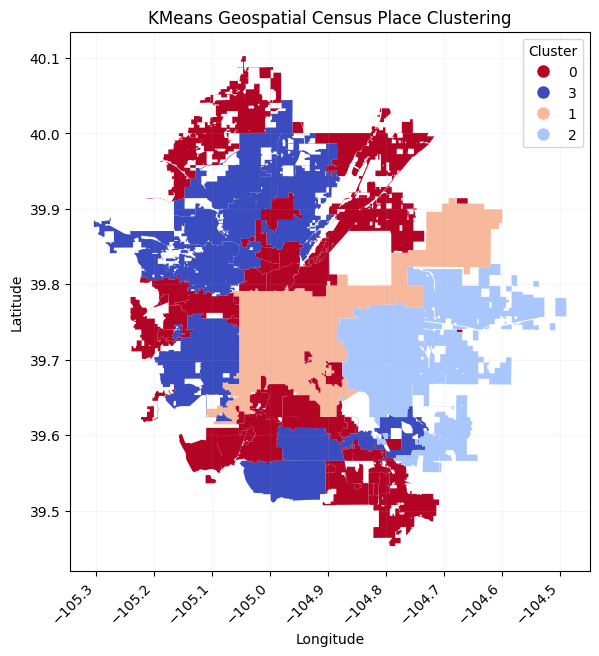

In [50]:
def plot_geospatial_clustering(gdf, clust_col, chart_title, colormap='coolwarm', saveFig=None):
    """Plot Census Place geometry w/ their corresponding cluster label
    params:
    gdf{GeoDataFrame} - GeoPandas GeoDataFrame which contains geospatial geometry for plotting
    clust_col{str} - the column of the GeoDataFrame which has the cluster label
    colormap{str} - the colormap to be used; depending on the clustering it's frequently advantageous to pick
    returns:
    Geospatial plot of KMeans clustering
    """
    # Create a colormap ScalarMappable to match the colormap used for the GeoDataFrame
    norm = Normalize(vmin=gdf[clust_col].min(), vmax=gdf[clust_col].max())
    sm = ScalarMappable(cmap=colormap, norm=norm)

    # Create a legend with color markers matching the colormap
    legend_values = gdf[clust_col].unique()

    legend_labels = [i for i in gdf[clust_col].unique()]  # Legend labels based on unique values
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                                 markersize=10, markerfacecolor=sm.to_rgba(value))
                      for label, value in zip(legend_labels, legend_values)]

    fig, ax = plt.subplots(figsize=(7, 7))
    gdf.plot(column=clust_col, cmap=colormap, ax=ax, legend=False)  # Disable default colorbar
    ax.set_title(f'{chart_title}')

    # Add custom legend
    ax.legend(handles=legend_handles, title='Cluster', loc='best')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xticks(ha='right', rotation=45)
    plt.grid(alpha=0.1)
    
    if saveFig is not None:
        os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/finalized_figures')
        plt.savefig(saveFig)

    return plt.show()


plot_geospatial_clustering(
    gdf_pca_demo,
    colormap='coolwarm_r', 
    clust_col='kmeans_label', 
    chart_title="KMeans Geospatial Census Place Clustering",
    saveFig='kmeans_geospatial_clustering.png'
)

In [8]:
def display_cluster_info(df, cluster_label_col):
    """Iterates through all clusters displaying important info including descriptive statistics.
    params:
    df{Pandas or GeoPandas DF/GeoDataFrame} - the dataframe holding the cluster label
    cluster_label_col{Pandas or Geopandas series} - the cluster label column of the dataframe
    returns:
    none - outputs 
    """
    print(df[cluster_label_col].nunique(), "clusters broken down as follows:")
    print(df[cluster_label_col].value_counts(), '\n')
    for i in df[cluster_label_col].value_counts().index:
        places = df[df[cluster_label_col] == i]
        print(f"CLUSTER {i}: {len(places)} Place(s) ({round(len(places)/len(df), 2):.2%} of all places)")
        if len(places) > 1:
            print(places.index.values)
            display(places.describe())
        elif len(places) == 1:
            display(places)
        
        
display_cluster_info(gdf_pca_demo, 'kmeans_label')

4 clusters broken down as follows:
kmeans_label
0    52
3     7
1     1
2     1
Name: count, dtype: int64 

CLUSTER 0: 52 Place(s) (85.00% of all places)
['Erie town' 'Meridian Village CDP' 'Shaw Heights CDP'
 'Mountain View town' 'Foxfield town' 'Sherrelwood CDP'
 'East Pleasant View CDP' 'Acres Green CDP' 'Inverness CDP'
 'Grand View Estates CDP' 'Welby CDP' 'Englewood city' 'Lafayette city'
 'Aetna Estates CDP' 'Cherry Hills Village city' 'Morrison town'
 'Wheat Ridge city' 'Four Square Mile CDP' 'Derby CDP' 'Ken Caryl CDP'
 'Stepping Stone CDP' 'Twin Lakes CDP' 'Stonegate CDP' 'Littleton city'
 'Columbine Valley town' 'Greenwood Village city' 'Parker town'
 'Louisville city' 'Applewood CDP' 'Columbine CDP' 'Edgewater city'
 'Brighton city' 'Berkley CDP' 'North Washington CDP' 'Todd Creek CDP'
 'Northglenn city' 'Sheridan city' 'Bow Mar town' 'Fairmount CDP'
 'Dove Valley CDP' 'Sierra Ridge CDP' 'Cherry Creek CDP'
 'West Pleasant View CDP' 'Lone Tree city' 'Superior town'
 'Holly Hi

,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,kmeans_label
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.0
mean,1.096154,1229.673077,1199.634615,8683.615385,2302.826923,1113.903846,6186.750000,800.730769,709.576923,1085.923077,592.865385,737.038462,2541.807692,2167.019231,2079.346154,1810.192308,5279.442308,11038.923077,3330.326923,4045.192308,0.0
std,1.785119,1505.377156,1381.359731,9415.430552,2571.915154,1289.222402,6663.919917,914.397565,820.897676,1252.822317,759.570726,841.913436,3067.604220,2402.476129,2363.707837,2002.317471,5631.882346,12347.655055,5236.071794,4336.742082,0.0
min,0.000000,0.000000,2.000000,8.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000,0.000000,4.000000,0.0
25%,0.000000,232.750000,155.000000,1851.000000,310.250000,266.500000,1336.500000,81.750000,90.500000,201.500000,106.750000,81.750000,415.000000,371.500000,447.250000,360.250000,998.750000,1936.750000,267.000000,777.000000,0.0
50%,0.000000,677.500000,646.000000,4298.500000,1311.000000,479.500000,3499.000000,434.000000,398.500000,496.000000,239.500000,350.500000,1331.000000,1249.500000,1189.000000,1153.000000,3317.500000,5966.000000,1024.000000,2379.000000,0.0
75%,2.000000,1644.250000,1614.750000,12943.250000,3075.750000,1573.000000,8084.000000,1101.500000,919.500000,1455.750000,777.250000,1248.000000,2939.000000,3157.750000,2911.250000,2574.500000,8062.500000,15037.250000,4371.500000,6212.750000,0.0
max,8.000000,7106.000000,5145.000000,34562.000000,10527.000000,5707.000000,25689.000000,3081.000000,2984.000000,5007.000000,3552.000000,3568.000000,12703.000000,8902.000000,9999.000000,8592.000000,20925.000000,48394.000000,29896.000000,16163.000000,0.0


CLUSTER 3: 7 Place(s) (11.00% of all places)
['Centennial city' 'Westminster city' 'Lakewood city' 'Thornton city'
 'Arvada city' 'Highlands Ranch CDP' 'Broomfield city']


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,kmeans_label
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0
mean,5.000000,10049.714286,10677.000000,76669.428571,17974.428571,9652.571429,52478.000000,7471.857143,6256.428571,9720.428571,5551.714286,6289.142857,23600.714286,17395.285714,17037.142857,15673.571429,44966.142857,95287.571429,22960.571429,34074.857143,3.0
std,1.414214,2159.176287,4377.730729,17396.848545,5381.220551,1825.689537,11462.521218,3006.377800,2039.032439,1993.330033,847.649832,2119.915205,4693.109336,6822.748388,3809.948312,2883.481915,11037.580931,20461.650136,16186.734300,8234.540534,0.0
min,3.000000,6690.000000,6789.000000,49148.000000,12956.000000,7429.000000,33883.000000,3978.000000,3675.000000,6421.000000,4148.000000,3917.000000,14026.000000,9913.000000,10708.000000,10235.000000,28134.000000,60366.000000,8713.000000,22088.000000,3.0
25%,4.000000,8880.000000,7610.500000,70865.500000,13784.000000,8051.000000,46623.000000,5208.500000,4634.500000,8966.000000,5027.000000,4900.500000,22857.500000,11685.500000,15438.000000,14422.500000,39474.000000,89381.000000,9551.000000,29666.000000,3.0
50%,5.000000,10386.000000,10175.000000,75410.000000,16303.000000,10106.000000,54554.000000,7969.000000,6691.000000,9149.000000,5875.000000,5986.000000,23997.000000,17911.000000,16559.000000,16725.000000,46070.000000,92354.000000,18661.000000,33572.000000,3.0
75%,6.000000,11229.000000,11514.000000,81858.500000,20628.000000,10992.500000,58102.000000,8589.000000,7440.000000,10977.500000,6094.500000,7260.500000,27055.500000,20950.500000,19722.000000,17856.500000,49179.000000,103841.000000,31342.500000,37774.500000,3.0
max,7.000000,13054.000000,19526.000000,106680.000000,27738.000000,11946.000000,69459.000000,12761.000000,9280.000000,12586.000000,6596.000000,9799.000000,27356.000000,28671.000000,21673.000000,18197.000000,63253.000000,127849.000000,51563.000000,47983.000000,3.0


CLUSTER 1: 1 Place(s) (2.00% of all places)


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,geometry,kmeans_label
NAMELSAD,,,,,,,,,,,,,,,,,,,,,,
Denver city,77,45855,94500,462861,138640,69543,341439,53145,38857,53482,30025,39706,116380,163445,116263,82611,286847,486538,208046,237443,"MULTIPOLYGON (((-104.93413 39.70018, -104.9328...",1


CLUSTER 2: 1 Place(s) (2.00% of all places)


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,geometry,kmeans_label
NAMELSAD,,,,,,,,,,,,,,,,,,,,,,
Aurora city,12,28008,38212,220997,67542,21558,165892,27858,19581,26109,11204,9523,65860,62544,56344,48508,142932,213640,111359,108465,"MULTIPOLYGON (((-104.54589 39.80423, -104.5364...",2


### KMeans Model Outcome
* Please reference `PCA_places_PC1vsPC2_ROUND6.png` found within the PCA Model directory
* Our KMeans model created four clusters comprised of Census Bureau Places within the approximate Denver-Lakewood-Aurora MSA where four clusters has been determined to be optimal by the Within Cluster Sum of Squares (WCSS) AKA Elbow Method.
* We find that Denver and Aurora naturally create their own clusters, while interestingly Lakewood does not.
    - Denver, and Aurora have greater total populations w/in the approximate MSA (550K, 276K)
    - Clustering has stratified by total overall population, ultimately:
        - Overall total population will help determine relative frequencies of demographics. For example the expected value of men to women is roughly 50%-male-50%female in the general US population, which is reached according to the Law of Large Numbers.
        - cluster 0: 
            - captures 52 Census Places (85% of all Census Places)
            - min total population 8 (Lakeside)
            - max total population 40K
            - These Places are generally smaller cities or towns but includes Commerce City which has a population 21 and older of 40K
        - cluster 3
            - captures 7 Census Places (11% of all Census Places)
            - min total population 54K
            - max total population 124K
            - comprised of larger cities not quite as large as Denver nor Aurora: Centennial, Westminster, Lakewood, Thornton, Arvada, Highlands Ranch, Broomfield
        - cluster 1 - Denver
            - total population 550K
        - cluster 2 - Aurora
            - total population 276K
    - Outside of Denver and Aurora we have 2 intermixed regions (clusters 0, and 3) which are difficult to describe graphically--please reference the geospatial cluster plot above
    - Aetna Estates appears significantly different enough to be clustered into group 0 instead of Aurora
        - demographics in Aetna Estates are significantly different from the rest of the approximate metro area even though its isloated on 3 sides by Aurora:
            - 878 total population 21 and older (vs 32K average population 21 and older)
            - 251 people employed in target occupations (29% vs 41% on average across metro area)
            - 306 people not in labor force (35% vs 30% on average across metro area)
            - 541 total women 18 and older (62% vs 52% across metro area)
        - NOTE: small parcel of land NE of downtown Denver by the airport is actually part of Commerce City, the main body of which lies to the west of Denver International Airport

# Census Places - Agglomerative Clustering
Agglomerative clustering starts by considering each data point as an individual cluster and then iteratively merging the closest pairs of clusters based on a chosen distance metric, creating a hierarchy of clusters until all data points belong to a single cluster or until a specified stopping condition is met. This hierarchical representation allows for various levels of granularity in the resulting clustering solution, making it a versatile tool for uncovering structure in data.

## Determine Optimal Number of Clusters for Agglomerative Algorithm

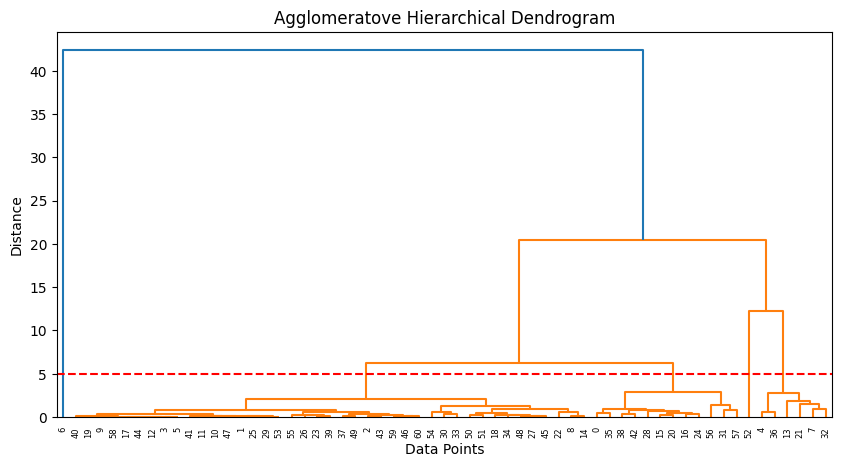

In [51]:
def create_dendrogram(pca_scaled_gdf_demo, horizontal_line):
    """Function to create a dendrogram which aids in understanding cluster hierarchy.
    params: 
    pca_scaled_gdf_demo{df} - scaled Pandas DF
    horizontal_line{int} - line used to determine optimal number of clusters
    returns: Hierarchical Dendrogram plot w/ a horizontal line
    """
    # Calculate linkage matrix
    Z = linkage(pca_scaled_gdf_demo, method='ward')

    # Plot the hierarchical dendrogram
    plt.figure(figsize=(10, 5))
    dendrogram(Z)
    plt.axhline(horizontal_line, color='red', linestyle='--');    # 2nd choice: n_clusers=3
    plt.title("Agglomeratove Hierarchical Dendrogram")
    plt.xlabel("Data Points")
    plt.ylabel("Distance")
    
    os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/finalized_figures')
    plt.savefig("agglomerative_hierarchical_dendrogram.png")
    
    return plt.show()


create_dendrogram(pca_scaled_gdf_demo, 5)

### Linkage Method: Single
* 'single' linkage minimizes the minimum pairwise distance between points in different clusters. This method is sensitive to noise and outliers, and can create long, elongated clusters. 
* Use is suitable when we want to detect elongated clusters and are less concerned about noise.
* We tested all available linkage methods and found this produced the best result for our dataset
    - other linkage methods include: ward, complete, average (an intermediate between ward and complete)

In [43]:
agglom = AgglomerativeClustering(n_clusters=5, linkage='single').fit(pca_scaled_gdf_demo)
gdf_pca_demo['aggl_label'] = agglom.labels_

### Silhouette Score
* Our 0.70 silhouette score, below, indicates that the Agglomerative-Hierarchical clustering model is not a bad fit, indicating that the clusters are frequently, but not always distinctly separated from each other

In [44]:
# Calculate silhouette score for Agglomerative Hierarchical clustering
silhouette_avg = silhouette_score(pca_scaled_gdf_demo, gdf_pca_demo['aggl_label'])
print(f"Agglomerative Clustering Silhouette Score: {round(silhouette_avg, 6)}")

Agglomerative Clustering Silhouette Score: 0.703828


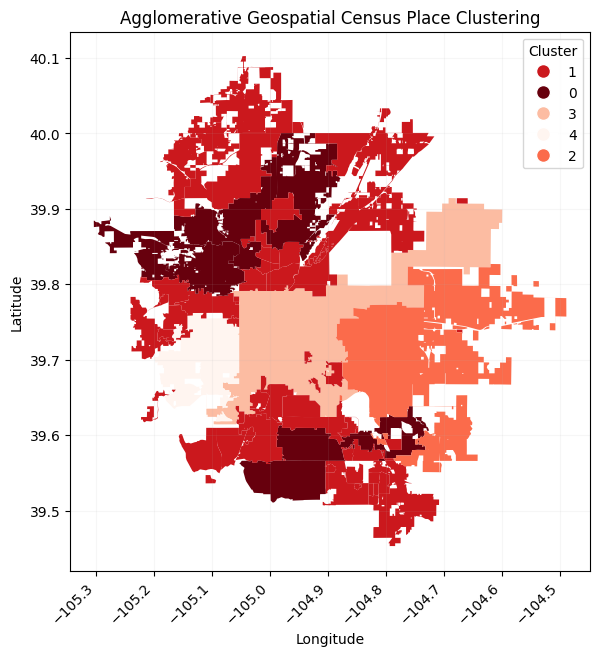

In [52]:
plot_geospatial_clustering(
    gdf_pca_demo,
    colormap='Reds_r', 
    clust_col='aggl_label', 
    chart_title="Agglomerative Geospatial Census Place Clustering",
    saveFig='agglomerative_geospatial_clustering.png'
)

In [47]:
display_cluster_info(gdf_pca_demo, 'aggl_label')

5 clusters broken down as follows:
aggl_label
1    53
0     5
3     1
4     1
2     1
Name: count, dtype: int64 

CLUSTER 1: 53 Place(s) (87.00% of all places)
['Erie town' 'Meridian Village CDP' 'Shaw Heights CDP'
 'Mountain View town' 'Foxfield town' 'Sherrelwood CDP'
 'East Pleasant View CDP' 'Acres Green CDP' 'Inverness CDP'
 'Grand View Estates CDP' 'Welby CDP' 'Englewood city' 'Lafayette city'
 'Aetna Estates CDP' 'Cherry Hills Village city' 'Morrison town'
 'Wheat Ridge city' 'Four Square Mile CDP' 'Derby CDP' 'Ken Caryl CDP'
 'Stepping Stone CDP' 'Twin Lakes CDP' 'Stonegate CDP' 'Littleton city'
 'Columbine Valley town' 'Greenwood Village city' 'Parker town'
 'Louisville city' 'Applewood CDP' 'Columbine CDP' 'Edgewater city'
 'Brighton city' 'Berkley CDP' 'North Washington CDP' 'Todd Creek CDP'
 'Northglenn city' 'Sheridan city' 'Bow Mar town' 'Fairmount CDP'
 'Dove Valley CDP' 'Sierra Ridge CDP' 'Cherry Creek CDP'
 'West Pleasant View CDP' 'Lone Tree city' 'Superior town'
 'Ho

,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,kmeans_label,aggl_label,dbscan_label
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.0,53.0
mean,1.150943,1332.698113,1305.094340,9447.094340,2503.830189,1243.358491,6709.320755,871.698113,765.528302,1186.584906,659.943396,825.396226,2758.490566,2336.849057,2242.150943,1969.150943,5710.660377,11969.622642,3445.018868,4385.622642,0.056604,1.0,0.0
std,1.812311,1668.871101,1568.729536,10855.377675,2937.492715,1586.925270,7617.550933,1042.578969,909.303804,1440.978293,896.841068,1053.073183,3423.106504,2681.329639,2623.824765,2295.946373,6400.268242,13980.030870,5252.274106,4958.625966,0.412082,0.0,0.0
min,0.000000,0.000000,2.000000,8.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000,0.000000,4.000000,0.000000,1.0,0.0
25%,0.000000,233.000000,168.000000,1865.000000,312.000000,270.000000,1379.000000,85.000000,91.000000,213.000000,107.000000,83.000000,419.000000,379.000000,462.000000,373.000000,1022.000000,1996.000000,270.000000,778.000000,0.000000,1.0,0.0
50%,0.000000,715.000000,684.000000,4487.000000,1384.000000,499.000000,3573.000000,450.000000,428.000000,498.000000,264.000000,354.000000,1352.000000,1250.000000,1189.000000,1158.000000,3323.000000,6003.000000,1114.000000,2532.000000,0.000000,1.0,0.0
75%,2.000000,1735.000000,1794.000000,14483.000000,3456.000000,1594.000000,8963.000000,1193.000000,984.000000,1686.000000,856.000000,1281.000000,3125.000000,3199.000000,3143.000000,2606.000000,8178.000000,17891.000000,5096.000000,6521.000000,0.000000,1.0,0.0
max,8.000000,7106.000000,6789.000000,49148.000000,12956.000000,7975.000000,33883.000000,4562.000000,3675.000000,6421.000000,4148.000000,5420.000000,14026.000000,11168.000000,10708.000000,10235.000000,28134.000000,60366.000000,29896.000000,22088.000000,3.000000,1.0,0.0


CLUSTER 0: 5 Place(s) (8.00% of all places)
['Centennial city' 'Westminster city' 'Thornton city' 'Arvada city'
 'Highlands Ranch CDP']


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,kmeans_label,aggl_label,dbscan_label
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.0,5.0
mean,5.000000,10839.000000,9684.800000,76171.600000,17025.400000,9589.200000,52800.800000,6996.000000,6168.000000,9807.200000,5729.000000,6523.600000,24791.800000,16385.600000,17375.800000,16354.800000,44675.200000,95759.600000,23190.800000,33690.600000,3.0,0.0,1.0
std,1.581139,1818.342652,2039.822835,6256.984921,3490.343078,1815.680506,6198.527462,2040.547966,1508.398488,1084.529022,692.082365,2541.755653,2251.879371,5202.913299,2498.578236,1861.291272,5310.737727,7602.596944,17566.882626,4152.905525,0.0,0.0,0.0
min,3.000000,8297.000000,6882.000000,67869.000000,13141.000000,7429.000000,46273.000000,3978.000000,4195.000000,8835.000000,4980.000000,3917.000000,22087.000000,9913.000000,14887.000000,14168.000000,37570.000000,89235.000000,8713.000000,28709.000000,3.0,0.0,1.0
25%,4.000000,10386.000000,8339.000000,73862.000000,14427.000000,8127.000000,46973.000000,5855.000000,5074.000000,9097.000000,5074.000000,4381.000000,23628.000000,12203.000000,15989.000000,14677.000000,41378.000000,89527.000000,9693.000000,30623.000000,3.0,0.0,1.0
50%,5.000000,10408.000000,10175.000000,75410.000000,16303.000000,10106.000000,54554.000000,7969.000000,6691.000000,9149.000000,5875.000000,6111.000000,23997.000000,17911.000000,16559.000000,16725.000000,46070.000000,92354.000000,18661.000000,33572.000000,3.0,0.0,1.0
75%,6.000000,12050.000000,11365.000000,78937.000000,20175.000000,10338.000000,55116.000000,8255.000000,6939.000000,10774.000000,6120.000000,8410.000000,26891.000000,19387.000000,18113.000000,18007.000000,47064.000000,101896.000000,27324.000000,36941.000000,3.0,0.0,1.0
max,7.000000,13054.000000,11663.000000,84780.000000,21081.000000,11946.000000,61088.000000,8923.000000,7941.000000,11181.000000,6596.000000,9799.000000,27356.000000,22514.000000,21331.000000,18197.000000,51294.000000,105786.000000,51563.000000,38608.000000,3.0,0.0,1.0


CLUSTER 3: 1 Place(s) (2.00% of all places)


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,geometry,kmeans_label,aggl_label,dbscan_label
NAMELSAD,,,,,,,,,,,,,,,,,,,,,,,,
Denver city,77,45855,94500,462861,138640,69543,341439,53145,38857,53482,30025,39706,116380,163445,116263,82611,286847,486538,208046,237443,"MULTIPOLYGON (((-104.93413 39.70018, -104.9328...",1,3,2


CLUSTER 4: 1 Place(s) (2.00% of all places)


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,geometry,kmeans_label,aggl_label,dbscan_label
NAMELSAD,,,,,,,,,,,,,,,,,,,,,,,,
Lakewood city,6,9463,19526,106680,27738,11647,69459,12761,9280,12586,6069,5986,27220,28671,21673,17706,63253,127849,35361,47983,"POLYGON ((-105.19967 39.70125, -105.19892 39.7...",3,4,3


CLUSTER 2: 1 Place(s) (2.00% of all places)


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,geometry,kmeans_label,aggl_label,dbscan_label
NAMELSAD,,,,,,,,,,,,,,,,,,,,,,,,
Aurora city,12,28008,38212,220997,67542,21558,165892,27858,19581,26109,11204,9523,65860,62544,56344,48508,142932,213640,111359,108465,"MULTIPOLYGON (((-104.54589 39.80423, -104.5364...",2,2,4


### Agglomerative Clustering Outcome
* Please reference `PCA_places_PC1vsPC2_ROUND6.png` found within the PCA Model directory
* Our Agglomeratice model has an optimum of 5-clusters comprised of Census Bureau Places within the approximate Denver-Lakewood-Aurora MSA.
* For Agglomerative clustering we must choose our number of clusters, unless we rely on the algorithm's linkage parameter to decide this for us. If we rely on the 'single' linkage method's default number of clusters we will arrive at just 2-clusters, Denver and everywhere else, which is too simplistic.  The choice of linkage method determines how clusters are merged, and the algorithm will continue merging clusters until the specified linkage criterion is met. Linkeage determines how the distance between clusters is calculated when merging them into larger clusters. We have chosen single linkage which iteratively merges the two closest clusters until the desired number of clusters is reached, forming a hierarchical clustering structure.
    - We can use a dendrogram to help aid us in determining an optimal number of clusters 
        - vertical lines on the dendrogram indicate distance or similarity between clusters, and therefore a large y-axis difference in values indicates dissimilarity. Interpreting graphically, if splits are vertically compressed, or squished then these differences are smaller in magnitude and the clusters are more similar.
            - we can use a horizontal line to determine the number of clusters: the number of vertical lines crossed will become the number of clusters
        - Our first 2 dendrogram splits have a large difference, followed by a smaller difference for the third and an even smaller difference for the fourth split and so on
        - after the fourth split the rate of return has a much smaller vertical distance of $\leq$ ~2.5.  Based off of this **5-clusters** appears appropriate
    - We know that our Census Places naturally divide into 11 or less clusters based off of our PCA (see `DenverCraftBreweries_EDA.ipynb` near the end of the file)

* We find that Denver, Aurora and Lakewood, naturally create their own clusters
    - Denver, Aurora, and Lakewood have greater total populations w/in the approximate MSA (550K, 276K, 124K)
    - Clustering has largely stratified by total overall population, but not exclusively in this case (see cluster 0 and 1 below):
        - cluster 1: 
            - captures 53 Census Places (87% of Census Places)
            - min total population 8 (Lakeside)
            - max total population 54K (Broomfield)
            - Places are generally smaller cities or towns, w/ several larger Places including Broomfield, Commerce City, Parker, Littleton, Brighton, Englewood, Northglenn, Wheat Ridge, Ken Caryl, Lafayette, Columbine, Four Square Mile, Lousiville, Golden which have total populations 21 and older of about 10K or greater
            - compared to cluster 0 (next) there are a lower number of breweries
                - 1.15 breweries on average
        - cluster 0
            - captures 5 Census Places (8% of Census Places)
            - min total population 73K (Highlands Ranch)
            - max total population 97K (Thornton)
            - comprised of cities not quite as large as cluster 2: Centennial, Westminster, Thornton, Arvada, Highlands Ranch
            - as compared to cluster 1 we are more likely to see a brewery per Census place, and more diversity according to the descriptive statistics
                - 5 breweries per Census Place on average
        - cluster 3 - Denver
            - total population 21 and older 550K
            - 77 breweries
        - Cluster 4 - Lakewood
            - total population 21 and older 124K
            - 6 breweries
        - cluster 2 - Aurora
            - total population 21 and older 276K
            - 12 breweries
    - Outside of Denver, Aurora, and Lakewood we have 2 intermixed regions (Clusters 0 and 1) which are difficult to describe graphically--please reference the geospatial cluster plot
    - Aetna Estates is included in Cluster 1 with 53 total Census Places with an overall smaller total population 21 and older

## Census Places - DBSCAN Clustering (Unsupervised ML)
DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise.  Density-based Clustering locates regions of high [cluster] density and separates them from other regions with low density. Density, in this context, is defined as the number of points within a specified radius and is a comparative measure.  DBSCAN is an unsupervised Machine Learning algorithm.  DBSCAN is unimpacted by noise.
* We can use higher point densities to form clusters of close or similar points
    - this effecitvely mimicks how a human being might attempt to group points together visually into clusters
    - can go over 3-dimensions
* Core points elaborated on below can extend a cluster
* Non-core points which are adjacent to core points, can join a cluster, however, cannot extend a cluster any further
* Outliers are points which do not belong to any clusters at conclusion of algorithm
* The following parameters must be specified for the algorithm:
    - the core point threshold (number of close points needed to classify a point as a core point) 
    - radius from a given point in which other nearby points are referenced

## Determine Optimal Epsilon Value for DBSCAN Algorithm
* Unsupervised Nearest Neighbors: https://scikit-learn.org/stable/modules/neighbors.html
* Epsilon: the radius of the neighborhood around each data point
* "Elbow" point in the k-distance plot, which indicates the transition from core points (closer neighbors) to points in the noise region (more distant neighbors). 
* We are finding an epsilon value that effectively separates the dense regions from the sparse regions in the data, as it's a crucial step in defining clusters with DBSCAN. By visually inspecting the plot of sorted distances and looking for the point where the change is most pronounced, you aim to select an epsilon that aligns well with the natural density structure of your data. 

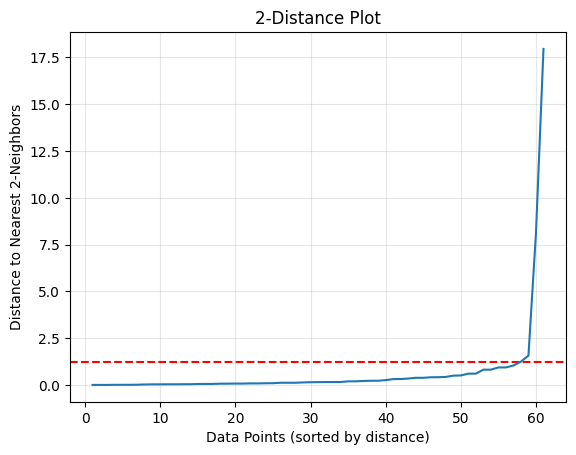

In [39]:
def dbscan_plot_epilon_values(df, elbow=0):
    """Function to plot Epislon values of nearest 2-neighbors to aid in determining optimal
    DBSCAN parameter epsilon.
    params:
    df{Pandas DF or GeoPandas GDF} - this should be scaled, if not using only (lat,long) coordinate pairs
    elbow{int} - fits a horizontal line to the elbow plot indicating the optimal epsilon values
    returns:
    matplotlib 2-distance plot
    """
    # n_neighbors is the number of closest neighbors to use; the points itself is included in n_neighbors
    nbrs = NearestNeighbors(n_neighbors=2).fit(df)

    # Calculate the distances and indices of the k-nearest neighbors for each point
    distances, indices = nbrs.kneighbors(df)

    # Sort the distances to get the k-distance for each point
    k_distances = np.sort(distances, axis=0)
    k_distances = k_distances[:, 1]
    # k_distances = k_distances[40:61]

    plt.title(f"2-Distance Plot")
    plt.xlabel("Data Points (sorted by distance)")
    plt.ylabel(f"Distance to Nearest 2-Neighbors")

    # plt.axvline(57, linestyle='--', color='r');
    plt.axhline(elbow, linestyle='--', color='r');
    plt.grid(alpha=0.3);

    plt.plot(range(1, len(df) + 1), k_distances);
    
    os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/finalized_figures')
    plt.savefig('dbscan_2distance.png')
    
    return plt.show()
    

dbscan_plot_epilon_values(pca_scaled_gdf_demo, 1.26)

In [16]:
# DBSCAN algorithm - NOTE: Haversine only applies to 2-D data
dbs = DBSCAN(eps=1.26, min_samples=1, metric='euclidean')
dbs.fit(pca_scaled_gdf_demo)  
gdf_pca_demo["dbscan_label"] = dbs.labels_

### Silhouette Score
* Our 0.70 silhouette score, below, indicates that the DBSCAN clustering model is not a bad fit, indicating that the clusters are frequently, but not always distinctly separated from each other.  This is also the same Silhouette score we obtained for agglomerative clustering above.
* Note: we can obtain a 0.842 silhouette score by using the Chebyshev metric for the DBSCAN algorithm, however, this results in just 2 clusters (Denver and everywhere else) which is too simplistic for our purposes

In [17]:
# Calculate silhouette score for KMeans clustering
silhouette_avg = silhouette_score(pca_scaled_gdf_demo, gdf_pca_demo['dbscan_label'])
print(f"KMeans Clustering Silhouette Score: {round(silhouette_avg, 6)}")

KMeans Clustering Silhouette Score: 0.703828


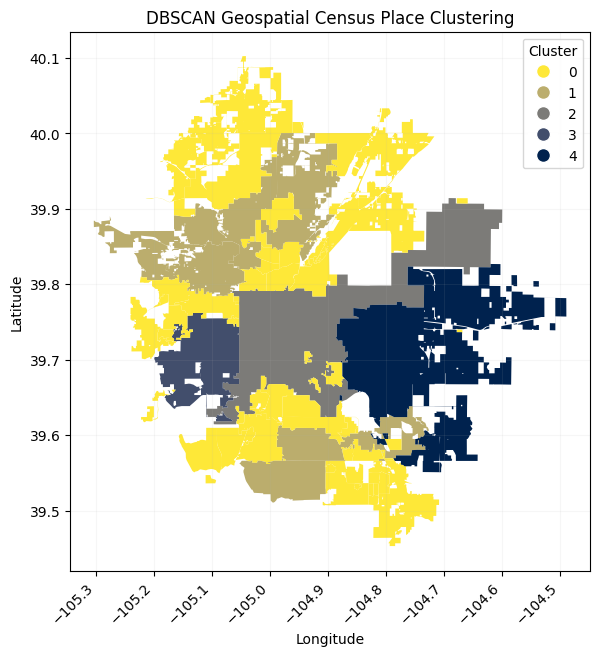

In [36]:
plot_geospatial_clustering(
    gdf_pca_demo,
    colormap='cividis_r', 
    clust_col='dbscan_label', 
    chart_title="DBSCAN Geospatial Census Place Clustering",
    saveFig='dbscan_geospatial_clustering.png'
)

In [48]:
display_cluster_info(gdf_pca_demo, 'dbscan_label')

5 clusters broken down as follows:
dbscan_label
0    53
1     5
2     1
3     1
4     1
Name: count, dtype: int64 

CLUSTER 0: 53 Place(s) (87.00% of all places)
['Erie town' 'Meridian Village CDP' 'Shaw Heights CDP'
 'Mountain View town' 'Foxfield town' 'Sherrelwood CDP'
 'East Pleasant View CDP' 'Acres Green CDP' 'Inverness CDP'
 'Grand View Estates CDP' 'Welby CDP' 'Englewood city' 'Lafayette city'
 'Aetna Estates CDP' 'Cherry Hills Village city' 'Morrison town'
 'Wheat Ridge city' 'Four Square Mile CDP' 'Derby CDP' 'Ken Caryl CDP'
 'Stepping Stone CDP' 'Twin Lakes CDP' 'Stonegate CDP' 'Littleton city'
 'Columbine Valley town' 'Greenwood Village city' 'Parker town'
 'Louisville city' 'Applewood CDP' 'Columbine CDP' 'Edgewater city'
 'Brighton city' 'Berkley CDP' 'North Washington CDP' 'Todd Creek CDP'
 'Northglenn city' 'Sheridan city' 'Bow Mar town' 'Fairmount CDP'
 'Dove Valley CDP' 'Sierra Ridge CDP' 'Cherry Creek CDP'
 'West Pleasant View CDP' 'Lone Tree city' 'Superior town'
 '

,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,kmeans_label,aggl_label,dbscan_label
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.0,53.0
mean,1.150943,1332.698113,1305.094340,9447.094340,2503.830189,1243.358491,6709.320755,871.698113,765.528302,1186.584906,659.943396,825.396226,2758.490566,2336.849057,2242.150943,1969.150943,5710.660377,11969.622642,3445.018868,4385.622642,0.056604,1.0,0.0
std,1.812311,1668.871101,1568.729536,10855.377675,2937.492715,1586.925270,7617.550933,1042.578969,909.303804,1440.978293,896.841068,1053.073183,3423.106504,2681.329639,2623.824765,2295.946373,6400.268242,13980.030870,5252.274106,4958.625966,0.412082,0.0,0.0
min,0.000000,0.000000,2.000000,8.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000,0.000000,4.000000,0.000000,1.0,0.0
25%,0.000000,233.000000,168.000000,1865.000000,312.000000,270.000000,1379.000000,85.000000,91.000000,213.000000,107.000000,83.000000,419.000000,379.000000,462.000000,373.000000,1022.000000,1996.000000,270.000000,778.000000,0.000000,1.0,0.0
50%,0.000000,715.000000,684.000000,4487.000000,1384.000000,499.000000,3573.000000,450.000000,428.000000,498.000000,264.000000,354.000000,1352.000000,1250.000000,1189.000000,1158.000000,3323.000000,6003.000000,1114.000000,2532.000000,0.000000,1.0,0.0
75%,2.000000,1735.000000,1794.000000,14483.000000,3456.000000,1594.000000,8963.000000,1193.000000,984.000000,1686.000000,856.000000,1281.000000,3125.000000,3199.000000,3143.000000,2606.000000,8178.000000,17891.000000,5096.000000,6521.000000,0.000000,1.0,0.0
max,8.000000,7106.000000,6789.000000,49148.000000,12956.000000,7975.000000,33883.000000,4562.000000,3675.000000,6421.000000,4148.000000,5420.000000,14026.000000,11168.000000,10708.000000,10235.000000,28134.000000,60366.000000,29896.000000,22088.000000,3.000000,1.0,0.0


CLUSTER 1: 5 Place(s) (8.00% of all places)
['Centennial city' 'Westminster city' 'Thornton city' 'Arvada city'
 'Highlands Ranch CDP']


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,kmeans_label,aggl_label,dbscan_label
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.0,5.0
mean,5.000000,10839.000000,9684.800000,76171.600000,17025.400000,9589.200000,52800.800000,6996.000000,6168.000000,9807.200000,5729.000000,6523.600000,24791.800000,16385.600000,17375.800000,16354.800000,44675.200000,95759.600000,23190.800000,33690.600000,3.0,0.0,1.0
std,1.581139,1818.342652,2039.822835,6256.984921,3490.343078,1815.680506,6198.527462,2040.547966,1508.398488,1084.529022,692.082365,2541.755653,2251.879371,5202.913299,2498.578236,1861.291272,5310.737727,7602.596944,17566.882626,4152.905525,0.0,0.0,0.0
min,3.000000,8297.000000,6882.000000,67869.000000,13141.000000,7429.000000,46273.000000,3978.000000,4195.000000,8835.000000,4980.000000,3917.000000,22087.000000,9913.000000,14887.000000,14168.000000,37570.000000,89235.000000,8713.000000,28709.000000,3.0,0.0,1.0
25%,4.000000,10386.000000,8339.000000,73862.000000,14427.000000,8127.000000,46973.000000,5855.000000,5074.000000,9097.000000,5074.000000,4381.000000,23628.000000,12203.000000,15989.000000,14677.000000,41378.000000,89527.000000,9693.000000,30623.000000,3.0,0.0,1.0
50%,5.000000,10408.000000,10175.000000,75410.000000,16303.000000,10106.000000,54554.000000,7969.000000,6691.000000,9149.000000,5875.000000,6111.000000,23997.000000,17911.000000,16559.000000,16725.000000,46070.000000,92354.000000,18661.000000,33572.000000,3.0,0.0,1.0
75%,6.000000,12050.000000,11365.000000,78937.000000,20175.000000,10338.000000,55116.000000,8255.000000,6939.000000,10774.000000,6120.000000,8410.000000,26891.000000,19387.000000,18113.000000,18007.000000,47064.000000,101896.000000,27324.000000,36941.000000,3.0,0.0,1.0
max,7.000000,13054.000000,11663.000000,84780.000000,21081.000000,11946.000000,61088.000000,8923.000000,7941.000000,11181.000000,6596.000000,9799.000000,27356.000000,22514.000000,21331.000000,18197.000000,51294.000000,105786.000000,51563.000000,38608.000000,3.0,0.0,1.0


CLUSTER 2: 1 Place(s) (2.00% of all places)


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,geometry,kmeans_label,aggl_label,dbscan_label
NAMELSAD,,,,,,,,,,,,,,,,,,,,,,,,
Denver city,77,45855,94500,462861,138640,69543,341439,53145,38857,53482,30025,39706,116380,163445,116263,82611,286847,486538,208046,237443,"MULTIPOLYGON (((-104.93413 39.70018, -104.9328...",1,3,2


CLUSTER 3: 1 Place(s) (2.00% of all places)


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,geometry,kmeans_label,aggl_label,dbscan_label
NAMELSAD,,,,,,,,,,,,,,,,,,,,,,,,
Lakewood city,6,9463,19526,106680,27738,11647,69459,12761,9280,12586,6069,5986,27220,28671,21673,17706,63253,127849,35361,47983,"POLYGON ((-105.19967 39.70125, -105.19892 39.7...",3,4,3


CLUSTER 4: 1 Place(s) (2.00% of all places)


,num_breweries,mar_child,hh_female,edu_>=_hs,diff_res_1yr,commute_wfh,private_wage_salary_worker,hhinc_50k-74.999k,hhinc_75k-99.999k,hhinc_100k-149.999k,hhinc_150k-199.999k,hhinc_>=200k,owner_occupied_mortgage,tot_pop_25-34,tot_pop_35-44,tot_pop_45-54,tot_pop_>=18_male,tot_pop_white,tot_pop_hisp,target_occs,geometry,kmeans_label,aggl_label,dbscan_label
NAMELSAD,,,,,,,,,,,,,,,,,,,,,,,,
Aurora city,12,28008,38212,220997,67542,21558,165892,27858,19581,26109,11204,9523,65860,62544,56344,48508,142932,213640,111359,108465,"MULTIPOLYGON (((-104.54589 39.80423, -104.5364...",2,2,4


### DBSCAN Model Outcome
* Please reference `PCA_places_PC1vsPC2_ROUND6.png` found within the PCA Model directory
* DBSCAN appears to have produced the same geospatial clustering as agglomerative clustering above!
* DBSCAN automatically determines the optimum number of clusters and found for our dataset this to be 6.
* We find that several clusters are comprised of single cities: Denver, Aurora, Lakewood and Arvada.
    - Denver,  Aurora, Lakewood and Aurora have greater total populations 21 and older w/in the approximate MSA (550K, 276K, 124K, 93K)
    - Clustering has stratified by total overall population:
        - cluster 0: 
            - captures 53 Census Places (87% of Census Places)
            - min total population 8 (Lakeside)
            - max total population 54K (Broomfield)
            - Places are generally smaller cities or towns, w/ several larger Places including Broomfield, Commerce City, Parker, Littleton, Brighton, Englewood, Northglenn, Wheat Ridge, Ken Caryl, Lafayette, Columbine, Four Square Mile, Lousiville, Golden which have total populations 21 and older of about 10K or greater
            - compared to cluster 0 (next) there are a lower number of breweries
                - 1.15 breweries on average
        - cluster 1
            - captures 5 Census Places (8% of Census Places)
            - min total population 73K (Highlands Ranch)
            - max total population 97K (Thornton)
            - comprised of cities not quite as large as clusters 2-4: Centennial, Westminster, Thornton, Arvada, Highlands Ranch
            - as compared to cluster 1 we are more likely to see a brewery per Census place, and more diversity according to the descriptive statistics
                - 5 breweries per Census Place on average
        - cluster 2 - Denver
            - total population 21 and older 550K
            - 77 breweries
        - Cluster 3 - Lakewood
            - total population 21 and older 124K
            - 6 breweries
        - cluster 4 - Aurora
            - total population 21 and older 276K
            - 12 breweries
    - Outside of Denver, Aurora, and Lakewood we have 2 intermixed regions (Clusters 0 and 1) which are difficult to describe graphically--please reference the geospatial cluster plot
    - Aetna Estates is included in Cluster 1 with 53 total Census Places with an overall smaller total population 21 and older
    - Outside of Denver, Aurora, Lakewood and Arvada we have 2 intermixed regions (Clusters 0, 1 and 2) which are difficult to describe graphically--please reference the geospatial cluster plot

# Census Place Clustering Comparison
* Please reference `PCA_places_PC1vsPC2_ROUND6.png` found within the PCA Model directory

## Clustering Commonalities
* All clustering algorithms have used demographics which are reflective of, or a function of, an overall total population
    - the larger the population the more distinct a Census Place became when considering clustering
    - the larger the population the more probable it is to follow the Law of Large Numbers and meet expected values for US national averages
* Denver and Aurora are always their own unique cluster across all algorithms (KMeans, Agglomerative, DBSCAN)
* When there are inherently a greater number of clusters we find the algorithms will proceed to cluster smaller to mid-sized cities separately
* Agglomerative and DBSCAN have generated identical cluster groupings

## Differences
* Kmeans has 4 optimal clusters whereas Agglomerative and DBSCAN have 5 optimal clusters:
    - KMeans: 4
    - Agglomerative: 5
    - DBSCAN: 5
* More distinct clustering occurs concerning smaller and even mid-sized cities w/in the approximate MSA depending on the clustering method which is in part due to the different number of optimum clusters
* Generally, DBSCAN and agglomerative clustering have a greater ability to determine underlying structure within our dataset.
* Clustering largely follows our PCA: PC1 vs PC2 plot.  Agglomerative and DBSCAN cluster together Centennial, Westminster, Thornton, Arvada, Highlands Ranch which appears to follow PCA, if we primarily consider the x-axis (PC1) oriented groupings.

# Brewery Locations - DBSCAN Clustering (Unsupervised ML)
* DBSCAN w/ the 'haversine' metric is an ideal algorithm for geospatial coordinates
* The Haversine formula calculates the distance between two points on the surface of a sphere 
    - We can use this to approximate the Earth, although the Earth is actually ellipsoidal as it bulges in a band around the equator
* The Haversine distance takes into account the curvature of the Earth, making it a more accurate measure of distance between two geographical points compared to simple Euclidean distance, which doesn't consider the spherical nature of the Earth
* Haversine is limited to 2-d and therefore not applicable to our demographics dataframe above

## Load Breweries GeoDataFrame

In [55]:
def load_breweries_and_create_geospatial():
    """Function to load breweries df and then convert it to a GeoDataFrame from lat,lon pairs
    params: none
    returns: gdf_breweries{gdf} - brewery gdf
    """
    # load breweries gdf
    os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/\
data/Breweries/coloradobrewerylist')
    gdf_brew = pd.read_pickle('gdf_msa_coloradobrewerylist.pkl')

    gdf_breweries = gdf_brew[['brewery', 'city', 'zipcode', 'lat', 'lon']]

    gdf_breweries = gpd.GeoDataFrame(
        gdf_breweries, 
        geometry=gpd.points_from_xy(gdf_breweries['lon'], gdf_breweries['lon']), 
        crs="EPSG:4326"   # common coord system
    )
    print(len(gdf_breweries), "breweries")
    
    return gdf_breweries


gdf_breweries = load_breweries_and_create_geospatial()
# Create coordinate GeoDataFrame
gdf_brew_latlon = gdf_breweries[['lat', 'lon']]

181 breweries


## Determine Optimal Epsilon Value for DBSCAN Algorithm
* Unsupervised Nearest Neighbors: https://scikit-learn.org/stable/modules/neighbors.html
* In this case the optimal epsilon value is not immediately apparent, indicating that the dataset may not have optimal clustering

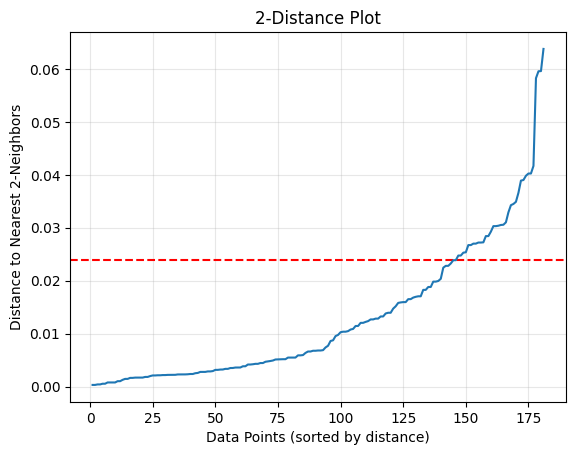

In [54]:
# Our elbow below is not as well defined which means points do not cluster as readily
dbscan_plot_epilon_values(gdf_brew_latlon, 0.024)

In [58]:
def get_colors(printColors=False):
    """Function to create a list of colors from all available colors in the Matplotlib library.
    params: printColors{bool} - if True prints out how many colors and the names of the colors
    returns: select_colors{list} - list of colors
    """
    # Get all named colors, a dictionary
    all_named_colors = mcolors.CSS4_COLORS

    # Convert the dictionary keys to a list to obtain all color names
    all_color_names = list(all_named_colors.keys())

    # Select specific colors--avoiding difficult to see colors when overlaid on Folium base map
    idx = [2, 3, 9, 11, 12, 19, 20, 21, 22, 25, 26, 27, 30, 31, 32, 33, 34, 36, 41, 
           45, 47, 48, 51, 52, 54, 55, 58, 59, 121, 122, 123, 139, 140, 141, 146]
    select_colors = [ all_color_names[i] for i in idx ]
    
    if printColors:
        print(len(idx), " total colors:\n", select_colors)
        
    return select_colors


select_colors = get_colors(printColors=False)
print(len(select_colors), ' colors:\n', select_colors, sep='')

35 colors:
['aqua', 'aquamarine', 'blue', 'brown', 'burlywood', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgreen', 'darkgrey', 'darkkhaki', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslategray', 'deepskyblue', 'firebrick', 'forestgreen', 'fuchsia', 'gold', 'goldenrod', 'green', 'greenyellow', 'hotpink', 'indianred', 'rosybrown', 'royalblue', 'saddlebrown', 'thistle', 'tomato', 'turquoise', 'yellow']


In [59]:
def brewery_dbscan(eps, min_samples, metric, printColors=False, printOutput=False):
    """Carries out DBSCAN on breweries.
    params:
    eps{float} - epsilon value for DBSCAN algorithm
    min_samples{int} - minimum number of samples to consider for a cluster
    metric{str} - metric parameter for DBSCAN algorith: haversine, euclidean, etc.
    printColors{bool} - if True prints color coded labels
    returns:
    Adds Dataframe columns 'dbscan_label', 'dbscan_labels_color' to gdf_breweries
    """
    dbs = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(gdf_brew_latlon) 
    gdf_breweries["dbscan_label"] = dbs.labels_ 
#     print(gdf_breweries['dbscan_label'].nunique(), "distinct clusters")
    gdf_breweries['dbscan_label'].value_counts()

    # Define a list of colors for clusters
    cluster_colors = select_colors
    color_coded_labels = []
    for i in gdf_breweries['dbscan_label']:
        # Get the corresponding color based on cluster_label
        color = cluster_colors[i % len(cluster_colors)]
        color_coded_labels.append(color)
    if printColors:
        print(len(color_coded_labels), color_coded_labels)
        
    silhouette_avg = silhouette_score(gdf_brew_latlon, gdf_breweries['dbscan_label'])
    if printOutput:
        # number clusters, silhouette score
        print(f"{gdf_breweries['dbscan_label'].nunique()} clusters, Silhouette Score: {silhouette_avg}")
        
    gdf_breweries['dbscan_labels_color'] = color_coded_labels
    return gdf_breweries['dbscan_label'].nunique(), silhouette_avg

### Optimal Number of Clusters
* If we use the Haversine metric over the range [0.007, 0.065] (see 2-Distance plot above) and begin at 0.007 we find that our silhouette score decreses at varying amounts until we arrive at epsilon=0.024 after which it sharply decreases until becoming negative.  After getting a negative Sihouette score it begins to increase, however, at the expense of fewer overall clusters, which are too simplistic. 
    - when reviewing the geospatial output we find at epislon=0.024 w/ 31 clusters we have an adequate representation of all brewery groupings throughout the approximate Denver MSA.

In [60]:
# Numerically determining optimal Epsilon value
for i in np.arange(0.007, 0.0651, 0.001):
    num_clust = brewery_dbscan(i, 1, 'haversine')[0]
    silhouette = brewery_dbscan(i, 1, 'haversine')[1]
    print(f"eps={np.round(i,3):<7}\t{num_clust} clusters\t{round(silhouette,4)} silhouette score")

eps=0.007  	105 clusters	0.2666 silhouette score
eps=0.008  	98 clusters	0.2491 silhouette score
eps=0.009  	90 clusters	0.2093 silhouette score
eps=0.01   	81 clusters	0.2844 silhouette score
eps=0.011  	73 clusters	0.2393 silhouette score
eps=0.012  	66 clusters	0.2556 silhouette score
eps=0.013  	64 clusters	0.248 silhouette score
eps=0.014  	59 clusters	0.1653 silhouette score
eps=0.015  	56 clusters	0.1547 silhouette score
eps=0.016  	50 clusters	0.1721 silhouette score
eps=0.017  	46 clusters	0.1843 silhouette score
eps=0.018  	43 clusters	0.1601 silhouette score
eps=0.019  	41 clusters	0.1956 silhouette score
eps=0.02   	38 clusters	0.1576 silhouette score
eps=0.021  	37 clusters	0.1827 silhouette score
eps=0.022  	37 clusters	0.1827 silhouette score
eps=0.023  	33 clusters	0.2098 silhouette score
eps=0.024  	31 clusters	0.2035 silhouette score
eps=0.025  	29 clusters	0.0997 silhouette score
eps=0.026  	27 clusters	0.1066 silhouette score
eps=0.027  	24 clusters	-0.0003 silhouet

### Silhouette Score
* Our 0.20 silhouette score, below, indicates that the DBSCAN clustering model is a poor fit.  This in turn indicates that the brewery clusters created are not distinctly separated from each other.
    - however, when a geospatial plot is reviewed along with our code cell immediately above we find an optimal brewery clustering of 31 clusters for 181 craft breweries

In [61]:
brewery_dbscan(0.024, 1, 'haversine', printOutput=True)

31 clusters, Silhouette Score: 0.20351284784001705


(31, 0.20351284784001705)

In [66]:
def create_brewery_markers(gdf, folium_base_map, size=3):
    """Add breweries as circle markers to a Folium base map.
    params:
    gdf{gdf} - geodataframe containing brewery geometries 
    folium_base_map{Folium map object} - base map upon which markers are superimposed
    size{int} - circle marker size
    returns:
    Folium map w/ clickable superimposed brewery markers
    """
    # create new layer
    brewery_layer = folium.FeatureGroup(
        name='Breweries', 
        overlay=True, 
        control=True, 
        show=True
    ).add_to(folium_base_map)
    
    # create brewery markers and add to folium_base_map
    for lat, lon, brewery, label in zip(gdf.lat, gdf.lon, gdf.brewery, gdf.dbscan_labels_color):
        folium.CircleMarker(
            [lat, lon],
            radius=size,
            color=label,
            popup=brewery,
            fill=True,
            fill_opacity=1,
            z_index=10000    # Set a high z_index to ensure this layer is always on top
        ).add_to(brewery_layer)
    
    return brewery_layer

def create_folium_brewery_plot(savePlot=False):
    """Function to create a Folium Marker plot
    params: savePlot{bool} - if True will save plot
    returns: Folium plot of breweries (as Folium Marker objects)
    """
    base_map = folium.Map(tiles='OpenStreetMap', location=[39.755, -104.9], zoom_start=10)
    layer = folium.FeatureGroup(name="Clustered Breweries", overlay=True, control=True, show=True)
    base_map.add_child(layer)

    # Add layer control to select different chorpleths
    folium.LayerControl(collapsed=False, position='topright').add_to(base_map)

    create_brewery_markers(gdf_breweries, layer, 3)
    
    # save the plot
    os.chdir("/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/finalized_figures")
    base_map.save("folium_dbscan_brewery_clustering.png")
    
    return base_map


create_folium_brewery_plot()

## Brewery Clustering Outcome
### Observations
* This analysis is based off of brewery geospatial coordinates only and thus presents a clustering of breweries based off of their proximity (aka density) to each other
* We find a large grouping of breweries clustered in the center of the approximate MSA which includes the urban core of downtown Denver and stretches in a NW to SE arrowhead-shape with one ear of the arrow in E Denver/Aurora and the other in Englewood.
    - includes areas immediately west of downtown Denver: Arvada, Wheat Ridge, Edgewater, etc.
    - moves south from downtown narrowly following I-25 to Englewood
    - includes area immediately east of downtown Denver along East Colfax Ave into Aurora
    - has an arrowhead base in SE Denver/NW Aurora
    - this is the largest single cluster of breweries
* We find a cluster of 5 breweries at Denver International Airport (DIA)
* There are 5 breweries within Aurora NE of Cherry Creek Reservoir
* There is a cluster of 16 breweries within the south central approximate MSA encompassing I-25 and breweries immediately adjacent to east of Chatfield Reservoir in the west. The southern boundary follows C-470 and breweries immediately south, on the northen boundary of Highlands Ranch
* We find a smal clustering of 4 breweries in Littleton
* There are 3 breweries NW of Chatfield [Lake] State Park
* There is a cluster of 4 breweries sparsely spreadout over central Lakewood
* 3 breweries form a cluster within the greater West Pleasant view-Applewood area and just east
* There is a cluter of 7 breweries near downtown Golden, or within the Golden boundary, including Coors brewery
* A cluster of 7 breweries stretching from Broomfield to Louisville
* A Cluster of 6 or so breweries in Lafayette
* a clustering of 3 or fewer breweries in the following cities:
    - Brighton
    - Erie
    - Northglenn
    - Parker

### Locations for Craft Breweries
* Our unsupervised clustering analysis of demographics presented earlier indicates that favorable craft beer drinker demographics are primarily influenced by the total population of individuals aged 21 and older. As the population size in the Denver-Lakewood-Aurora Metropolitan Statistical Area (MSA) increases, the Law of Large Numbers becomes more relevant, leading to a convergence of demographic frequencies towards their respective expected values.
    - Law of Large Numbers - This law states that as you take larger and larger samples (assuming they are randomly and independently selected), the sample means will tend to get closer and closer to the true population mean. In other words, the more data you collect, the more accurate your estimate of the population mean becomes.
* Our clustering algorithms stratified Census Places within the approximate Denver MSA largely according to total population, or more specifically total population 21 and older.  
    - Denver, Aurora, and Lakewood appear as distinct Census Places
    - We find a grouping of cities with total populations between roughly 70K - 100K:
        - Centennial
        - Westminster
        - Thornton
        - Highlands Ranch
        - Arvada
    - The remaining Census Places are largely smaller cities or towns dispersed throughout the approximate Denver MSA.
* A higher density of breweries are found in downtown Denver, Arvada, Centennial, Highlands Ranch and Golden.
    - Downtown Denver can be determined by looking on a map: 
        - it includes a grid of roads which deviate from the typical East-West North-South orientation, to a roughly triangular gridlock SW to NE and and NW to SE
        - Downtown Denver has 24 or more breweries depending on how many miles are included in an immedately adjacent estimation
* Aurora has a moderate concentration of breweries but also has a military base, and a spaceport, in addition to multiple medical facilities
* There are a lower concentration of breweries in Thornton, Lakewood, and Westminster but greater populations capable of supporting craft brewery patronage